# **GPU Demo Part 2 - Decoupler-GPU: Accelerated Transcriptional Regulatory Analysis**  

**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

**Please run [GPU Demo Part 1 - Basic GPU E2E Workflow](01_demo_gpu_e2e.ipynb) before running this notebook as this notebook continues some analysis of that notebook's output.**

In this notebook, we explore the updated [**Decoupler**](https://decoupler-py.readthedocs.io/en/latest/) functions for inferring transcriptional regulatory activity, leveraging the **GPU-accelerated** implementation from **rapids-singlecell**.  

By running these analyses on GPUs, we achieve **faster computation** and **scalability** for large single-cell datasets. We will apply **Decoupler** methods to estimate **transcription factor (TF) activity** and **pathway activity**, utilizing curated regulatory networks such as **Dorothea** and **PROGENy**.

In [6]:
import rapids_singlecell as rsc
import scanpy as sc
import rmm
import cupy as cp
import pandas as pd
import anndata as ad
import decoupler as dc
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=True, # default is False
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [7]:
adata = sc.read_h5ad("./h5/dli_decoupler.h5ad")

In [8]:
adata = adata.raw.to_adata()

In [9]:
rsc.get.anndata_to_GPU(adata)

### Retrieving Transcription Factor (TF) Regulons with Dorothea  

We start by retrieving the **Dorothea** gene regulatory network, which provides curated transcription factor (TF) target interactions.  
Dorothea assigns confidence levels (`A`, `B`, `C`, `D`, `E`), where `A` represents the highest confidence interactions.  
Here, we filter for **high-confidence** (`A`, `B`, `C`) interactions in human data:  

In [10]:
collectri = dc.op.collectri(organism="human",license="commercial")

### Transcription Factor Activity Inference with ULM  

To infer transcription factor (TF) activity, we use the **Univariate Linear Model (ULM)** from **Decoupler**.  
ULM estimates the regulatory influence of TFs on gene expression by fitting a linear model for each TF-gene interaction.  

We apply **ULM** using the **Dorothea** regulatory network retrieved earlier. 

In [11]:
%%time
rsc.dcg.ulm(adata, collectri, verbose=True, raw = False, pre_load=True)

2026-02-22 21:21:03 | [INFO] ulm - Running ulm
2026-02-22 21:21:03 | [INFO] Network adjacency matrix has 5930 unique features and 740 unique sources


  0%|          | 0/43 [00:00<?, ?it/s]

2026-02-22 21:21:03 | [INFO] ulm - fitting 740 univariate models of 25430 observations (targets) with 25428 degrees of freedom
2026-02-22 21:21:06 | [INFO] ulm - adjusting p-values by FDR
2026-02-22 21:21:07 | [INFO] ulm - done


CPU times: user 11.9 s, sys: 581 ms, total: 12.5 s
Wall time: 3.96 s


In [12]:
acts = dc.pp.get_obsm(adata=adata, key="score_ulm")

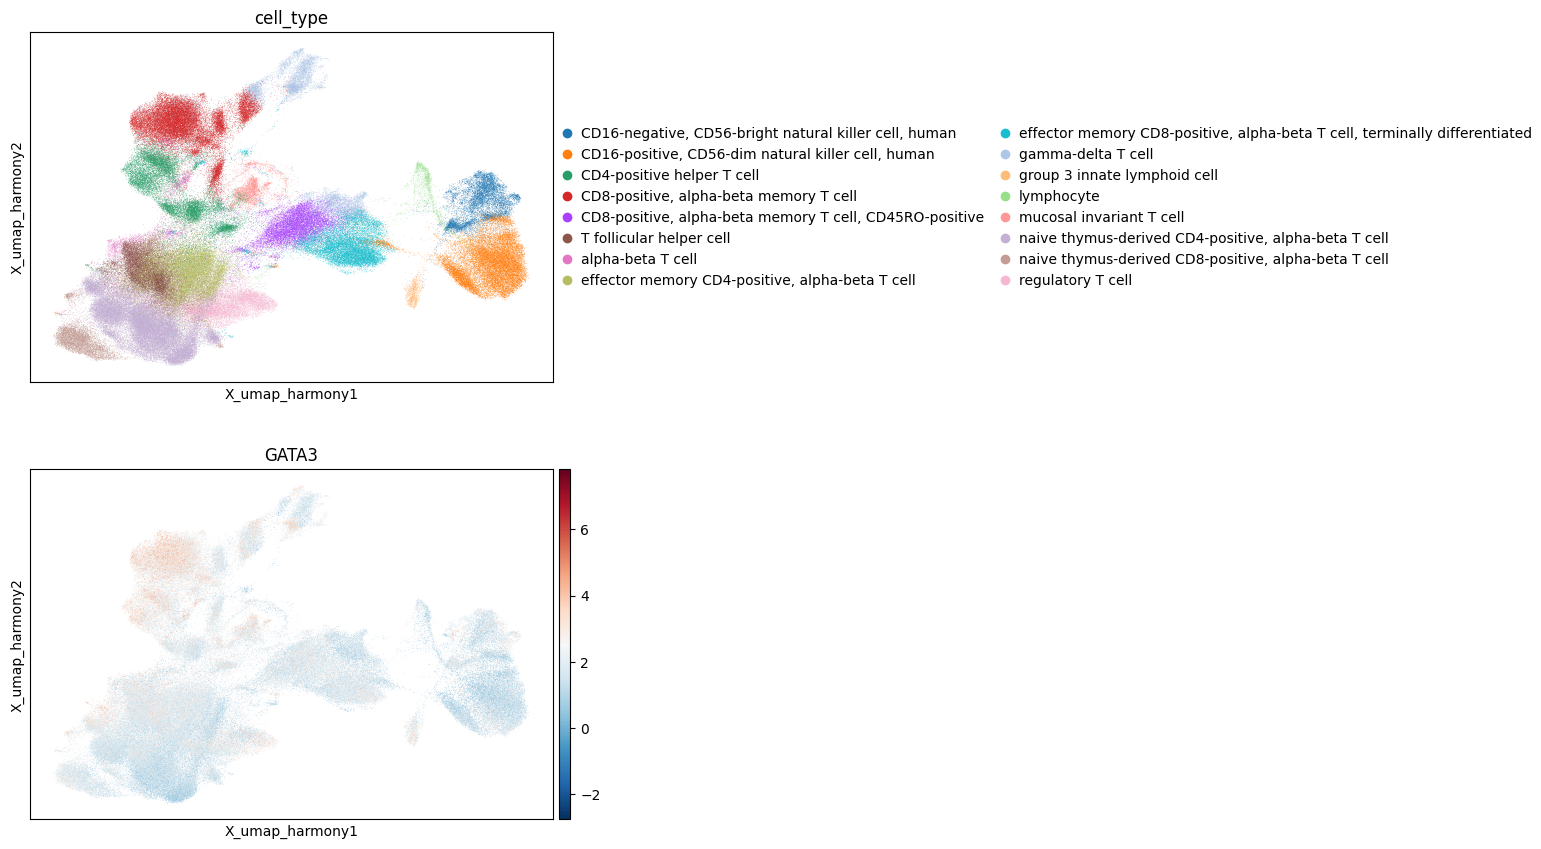

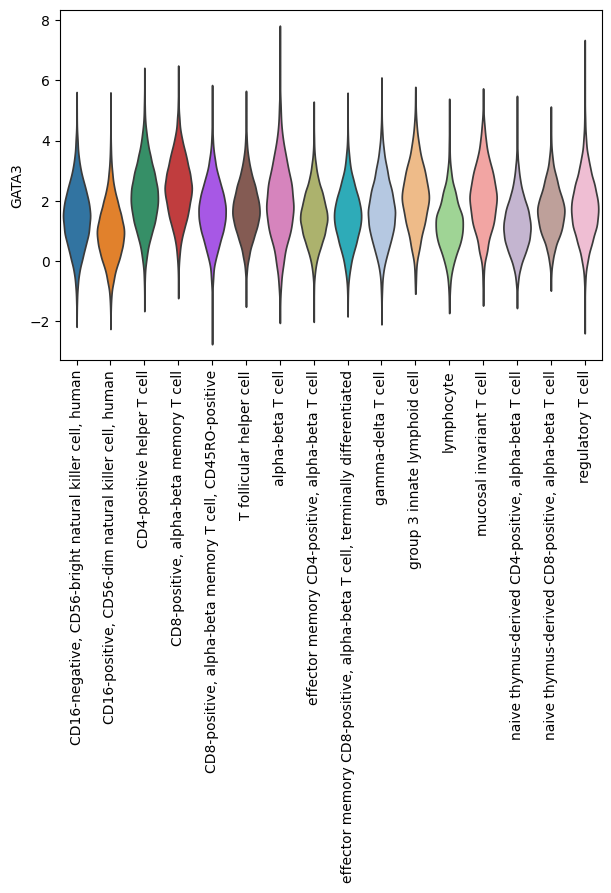

In [13]:
sc.pl.embedding(acts,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(acts, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


### Transcription Factor Activity Inference with MLM  

Next, we infer transcription factor (TF) activity using the **Multivariate Linear Model (MLM)** from **Decoupler**.  
Unlike **ULM**, which considers each TF independently, **MLM** accounts for multiple TFs simultaneously,  
providing a more comprehensive estimation of regulatory influences. 

In [15]:
%%time
rsc.dcg.mlm(adata, collectri, verbose=True, raw = False, pre_load=True)

2026-02-22 21:21:56 | [INFO] mlm - Running mlm
2026-02-22 21:21:56 | [INFO] Network adjacency matrix has 5930 unique features and 740 unique sources


  0%|          | 0/43 [00:00<?, ?it/s]

2026-02-22 21:21:56 | [INFO] mlm - fitting 740 multivariate models of 25430 observations with 24689 degrees of freedom
2026-02-22 21:22:04 | [INFO] mlm - done


CPU times: user 7.24 s, sys: 707 ms, total: 7.94 s
Wall time: 7.95 s


### Transcription Factor Activity Inference with AUCell  

Next, we infer transcription factor (TF) activity using **AUCell** from **Decoupler**.  
AUCell estimates TF activity based on the **enrichment of TF target genes within the top-expressed genes** in each cell.  
Unlike regression-based methods (**ULM**, **MLM**), AUCell is a **rank-based approach** that does not assume linear relationships. 

In [16]:
%%time
rsc.dcg.aucell(adata, collectri, verbose=True, raw = False, pre_load=True)

2026-02-22 21:22:04 | [INFO] aucell - Running aucell
2026-02-22 21:22:04 | [INFO] Network has 5930 unique features and 740 unique sources


  0%|          | 0/2131 [00:00<?, ?it/s]

2026-02-22 21:22:04 | [INFO] aucell - calculating 740 AUCs for 25430 targets across 100 observations, categorizing features at rank=1272
2026-02-22 21:22:06 | [INFO] aucell - done


CPU times: user 2.25 s, sys: 119 ms, total: 2.37 s
Wall time: 2.36 s


In [17]:
acts = dc.pp.get_obsm(adata=adata, key="score_aucell")

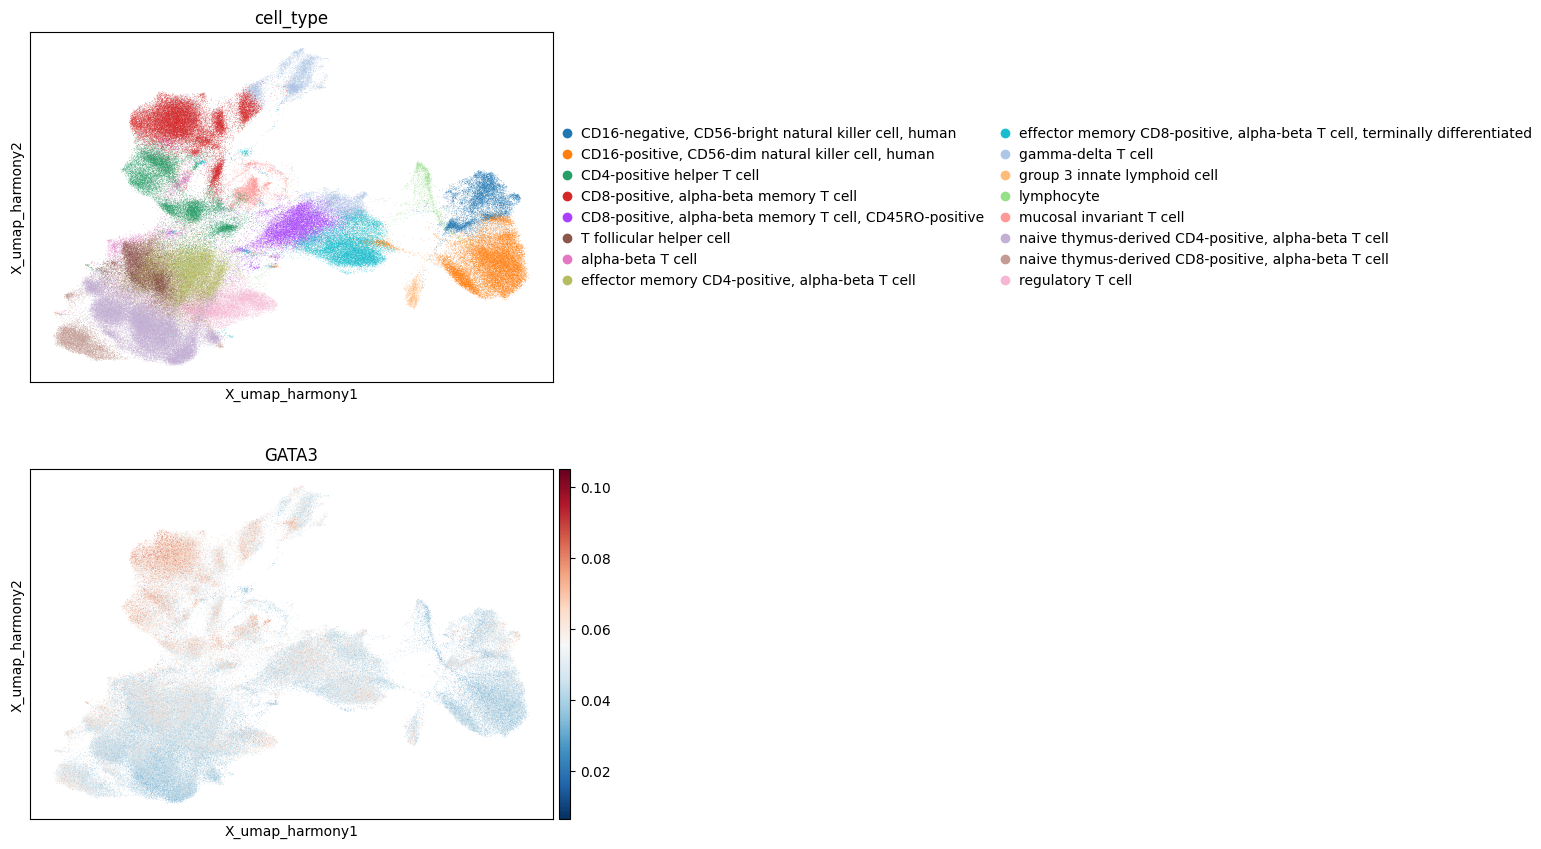

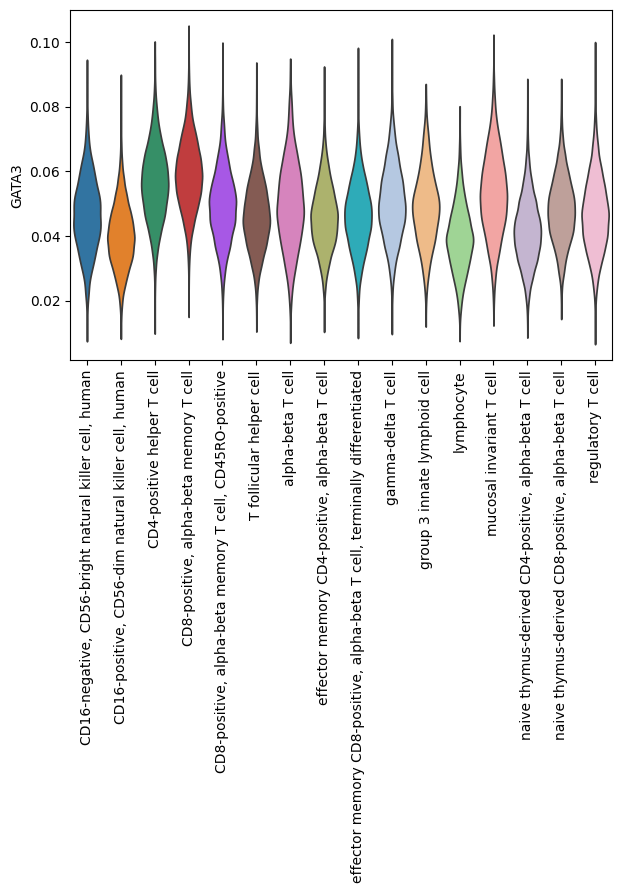

In [18]:
sc.pl.embedding(acts,basis="X_umap_harmony", color=["cell_type", "GATA3"], cmap='RdBu_r',ncols=1)
sc.pl.violin(acts, keys=['GATA3'], groupby='cell_type', rotation=90, size = 0)


### Retrieving Pathway Activity Models with PROGENy  

To assess pathway activity, we use **PROGENy**, a curated model that links gene expression to pathway activity scores.  
PROGENy provides a **data-driven** approach to infer the activity of major signaling pathways  
by leveraging transcriptional signatures derived from perturbation experiments.  

We retrieve the **top 100 most informative target genes** for each pathway in **human** data  

In [19]:
# These notebooks are very GPU memory intensive!
# In order to free up GPU memory, we'll kill this kernel prior to proceeding.  You will get a message.  This is expected.
# If you have a CUDA or an Out Of Memory (OOM) error, please kill all kernels to free up your GPU memory and try again!
# You can comment this out if you want to continue exploring the notebook.
# Please consult the README for more tips and tricks.

import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}